<h1 style="color:#4683B7; font-size: 60px; font-weight: bold;">Chatbot for Budget Planning</h1>
<style>
.highlight {
    background-color: #1A1C22; /* Background color */
    font-weight: bold;
    color: #FFFFFF; /* Text color */
    text-align: center; /* Center the text */
}
</style>

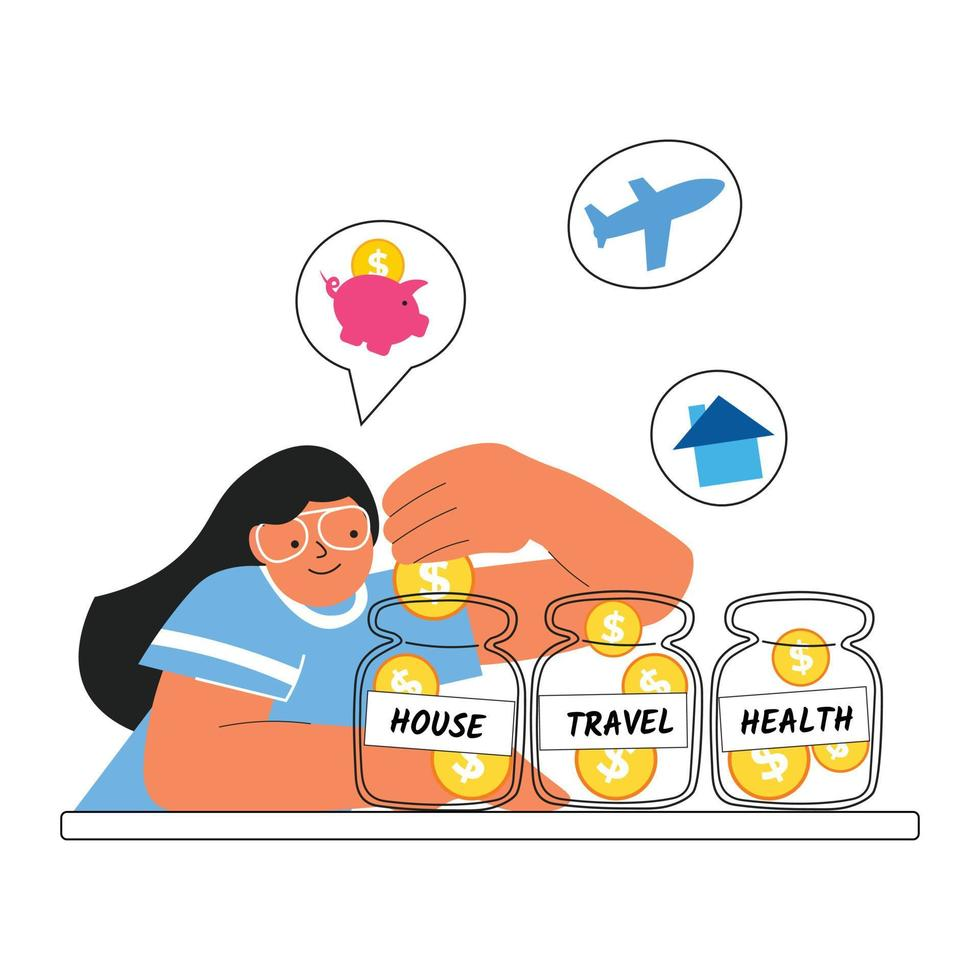
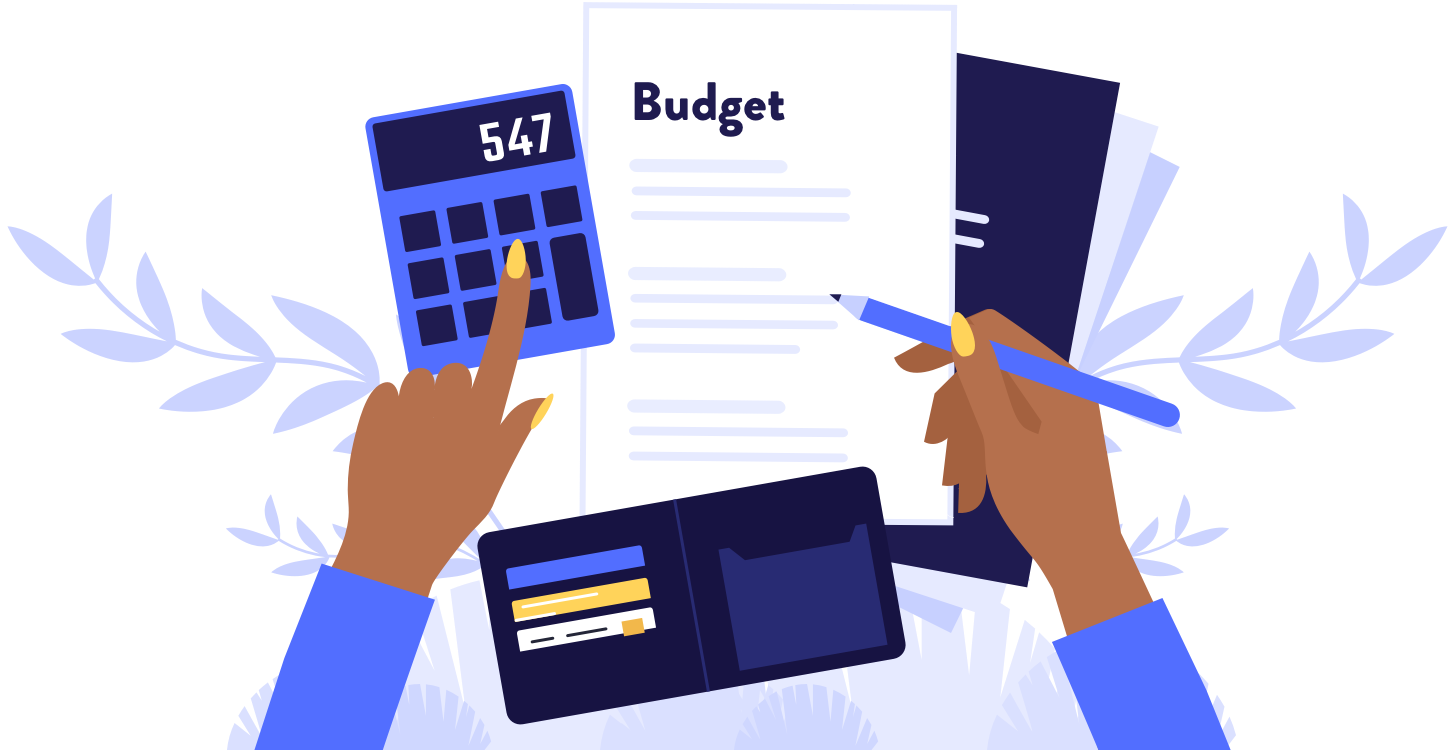
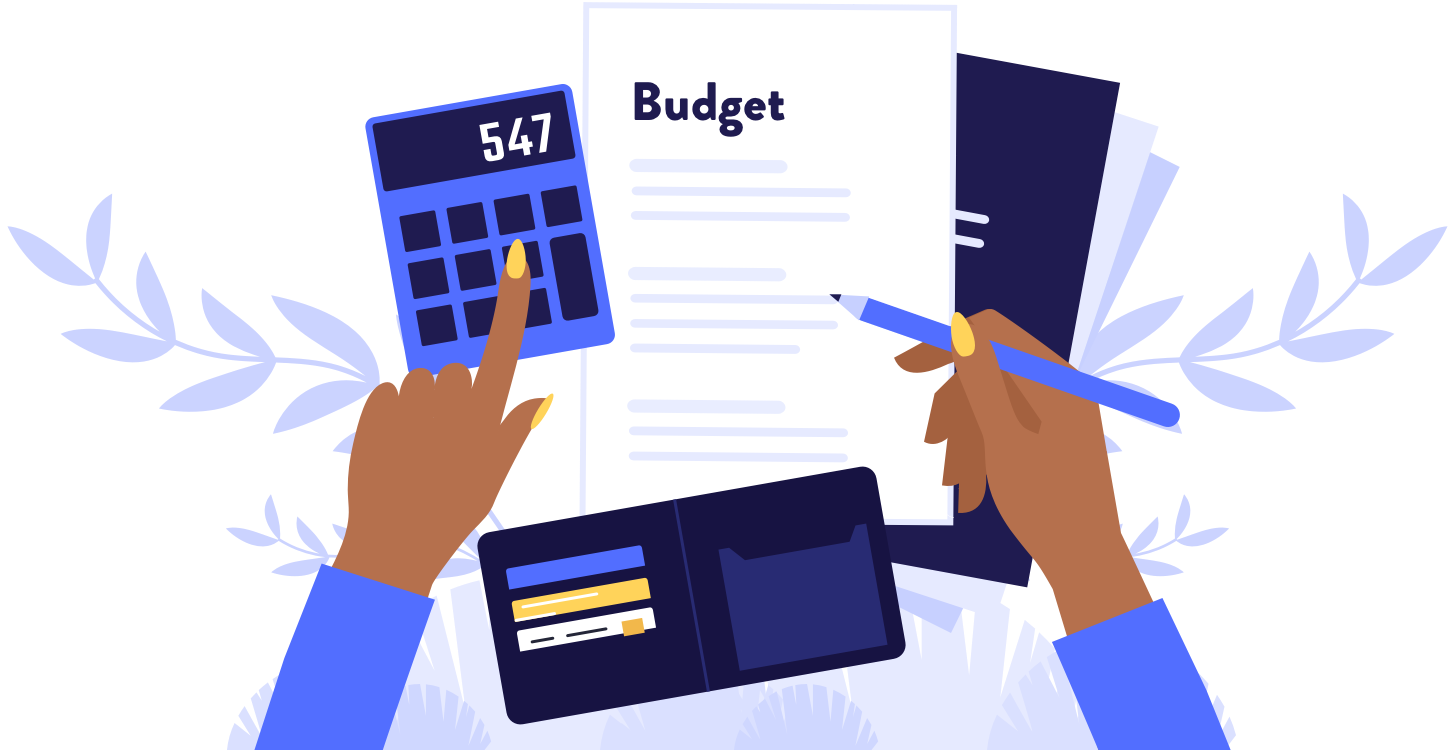
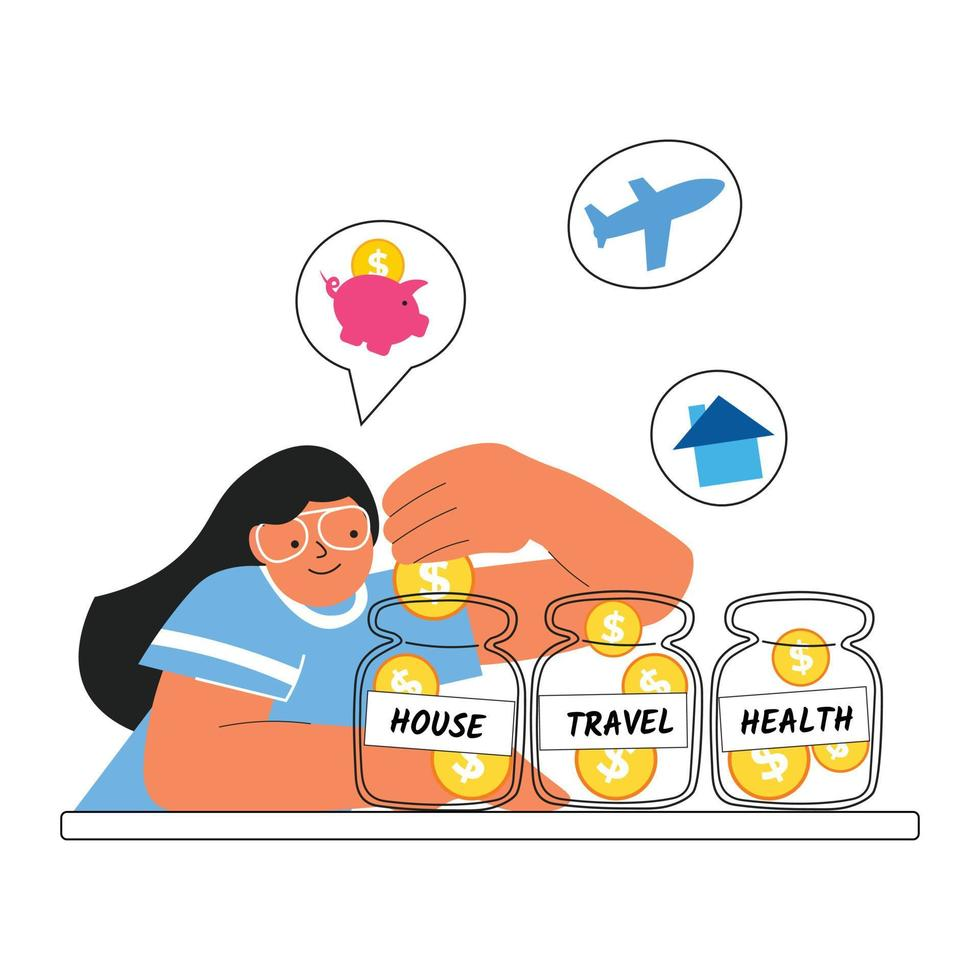

# **Upload & Import libraries**

In [1]:
!pip install crewai 
!pip install 'crewai[tools]'
!pip install google-cloud-aiplatform
!pip install -q langchain
!pip install -qU langchain-google-genai
!pip install langchain-google-genai google-generativeai
!pip install langtrace-python-sdk

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.0/42.0 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 3.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.8/41.8 kB 2.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.2/48.2 kB 2.7 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of google-api-core to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of google-api-core[grpc] to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 192.0/192.0 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 131.8/131.8 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
from crewai import Agent, Task, Crew, Process
from kaggle_secrets import UserSecretsClient
from langchain_google_genai import GoogleGenerativeAI
from langchain.tools import BaseTool
from typing import Dict, List
import os
import json

# **1. Configure Gemini**
# First, we'll set up the Gemini model configuration. 

In [4]:
def setup_gemini():
    # Get API key from Kaggle secrets
    user_secrets = UserSecretsClient()
    os.environ['GOOGLE_API_KEY'] = user_secrets.get_secret("API")
    
    # Initialize Gemini
    llm = GoogleGenerativeAI(
        model="gemini-pro",
        temperature=0.7
    )
    return llm


# **2. Define Custom Tools**
# Now we'll create our budget calculation and expense analysis tools.

In [5]:
from crewai.tools import BaseTool
from typing import Dict

class BudgetCalculatorTool(BaseTool):
    name: str = "budget_calculator"
    description: str = "Calculates budget allocations using the 50/30/20 rule"
    
    def _run(self, income: float) -> Dict:
        # Calculate budget allocations
        needs = income * 0.5
        wants = income * 0.3
        savings = income * 0.2
        
        return {
            "needs": needs,
            "wants": wants,
            "savings": savings,
            "monthly_income": income
        }

In [6]:
# Test BudgetCalculatorTool
calculator = BudgetCalculatorTool()
test_result = calculator._run(5000)
print("Budget Calculator Test:")
print(json.dumps(test_result, indent=2))

Budget Calculator Test:
{
  "needs": 2500.0,
  "wants": 1500.0,
  "savings": 1000.0,
  "monthly_income": 5000
}


In [7]:
class ExpenseAnalyzerTool(BaseTool):
    name: str = "expense_analyzer"
    description: str = "Analyzes expenses and identifies areas for improvement"

    def _run(self, budget_data: Dict) -> List[str]:
        tips = []
        monthly_income = budget_data.get('monthly_income', 0)
        actual_needs = budget_data.get('actual_needs', 0)
        actual_wants = budget_data.get('actual_wants', 0)

        if actual_needs > (monthly_income * 0.5):
            tips.append(f"Your essential expenses are higher than recommended. "
                       f"Look for ways to reduce fixed costs.")
            
        if actual_wants > (monthly_income * 0.3):
            tips.append(f"Consider reducing discretionary spending by "
                       f"${actual_wants - (monthly_income * 0.3):.2f} monthly.")

        return tips[:2]

In [8]:
# Test ExpenseAnalyzerTool
analyzer = ExpenseAnalyzerTool()
test_budget_data = {
    "monthly_income": 5000,
    "actual_needs": 3000,  # Higher than recommended 50%
    "actual_wants": 1800   # Higher than recommended 30%
}
test_tips = analyzer._run(test_budget_data)
print("\nExpense Analyzer Test:")
for tip in test_tips:
    print(f"- {tip}")


Expense Analyzer Test:
- Your essential expenses are higher than recommended. Look for ways to reduce fixed costs.
- Consider reducing discretionary spending by $300.00 monthly.


# **3. Create Agents and Tasks**
# Now we'll set up our CrewAI agents and their tasks.

In [9]:
def create_budget_crew(llm):
    # Financial Input Agent
    financial_agent = Agent(
        role='Financial Data Collector',
        goal='Collect and validate financial information from users',
        backstory="""I am an expert at gathering and organizing financial data. 
                    I ensure all numbers are valid and properly categorized.""",
        tools=[],
        llm=llm,
        verbose=True
    )
    
     # Budget Analysis Agent
    budget_agent = Agent(
        role='Budget Analyzer',
        goal='Create and analyze budgets using the 50/30/20 rule',
        backstory="""I am a financial advisor specialized in budget optimization. 
                    I analyze spending patterns and identify areas for improvement.""",
        tools=[BudgetCalculatorTool()],
        llm=llm,
        verbose=True
    )
     # Savings Advisor Agent
    savings_agent = Agent(
        role='Savings Advisor',
        goal='Provide personalized savings recommendations',
        backstory="""I am a savings expert who helps people achieve their financial goals. 
                    I provide actionable tips based on their specific situation.""",
        tools=[ExpenseAnalyzerTool()],
        llm=llm,
        verbose=True
    )

    tasks = [
        Task(
            description="""
            Collect and validate the following financial information from the user""",
            expected_output="""A JSON object containing validated financial data with monthly_income, 
                             fixed_expenses, and discretionary_expenses""",
            agent=financial_agent
        ),
        Task(
            description="""Calculate and analyze budget allocations using the 50/30/20 rule""",
            expected_output="""A JSON object containing budget calculations and spending analysis""",
            agent=budget_agent
        ),
        Task(
            description="""Generate specific savings recommendations based on the analysis""",
            expected_output="""A list of 1-2 prioritized, actionable savings tips""",
            agent=savings_agent
        )
    ]

    return Crew(
        agents=[financial_agent, budget_agent, savings_agent],
        tasks=tasks,
        process=Process.sequential
    )

    

# **4. Test the Complete System**
# Now let's test the entire system with sample user input.

In [10]:
def process_budget_request(user_input: str):
    try:
        llm = setup_gemini()
        crew = create_budget_crew(llm)
        result = crew.kickoff()
        return result
    except Exception as e:
        return f"An error occurred: {str(e)}"

# Test with sample input
test_input = """
My monthly income is $5000
My rent is $1500
Utilities are about $300
I spend around $1000 on food and entertainment
"""

print("Testing budget advisor with sample input:")
print("\nInput:")
print(test_input)
print("\nResponse:")
response = process_budget_request(test_input)
print(response)


Testing budget advisor with sample input:

Input:

My monthly income is $5000
My rent is $1500
Utilities are about $300
I spend around $1000 on food and entertainment


Response:
An error occurred: 'NoneType' object does not support item assignment
